In [ ]:
%run C:\Users\Omar\Intern_Final_Project\notebooks\Data_Cleaning\Features_Selection.ipynb

---
### *A.<BR> Importing needed libraries*

In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from lightgbm.sklearn import LGBMRegressor
import plotly as py
import plotly.graph_objs as go
import warnings                                  
warnings.filterwarnings('ignore')

---
### *B.<BR> Data Scalling*

In [4]:
'''def data_scale():   
     scaler = StandardScaler()
     for col in df_red:
           if col not in ["price"]:
                  df_red[col]=scaler.fit_transform(df_red[[col]])

     for col in df_green:
           if col not in ["price"]:
                  df_green[col]=scaler.fit_transform(df_green[[col]])

     for col in df_yellow:
           if col not in ["price"]:
                  df_yellow[col]=scaler.fit_transform(df_yellow[[col]])             


data_scale()'''

'def data_scale():   \n     scaler = StandardScaler()\n     for col in df_red:\n           if col not in ["price"]:\n                  df_red[col]=scaler.fit_transform(df_red[[col]])\n\n     for col in df_green:\n           if col not in ["price"]:\n                  df_green[col]=scaler.fit_transform(df_green[[col]])\n\n     for col in df_yellow:\n           if col not in ["price"]:\n                  df_yellow[col]=scaler.fit_transform(df_yellow[[col]])             \n\n\ndata_scale()'

---
### *C.<BR> Quick Comparison between multiple models with the default parameters*

#### *C.1 <BR>Creating one function to use over the three datasets*

In [40]:
def train_test(data):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    mae_scores = []
    y_pred_results=[]

    models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo"]
              
    models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0)]


    test_data=data[-20:]
    time_series_data = test_data.values

    for model in models:
              for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred = model.predict(X_test)
                                  y_pred_results.append(y_pred)
                                  mae = np.mean(mean_absolute_error(y_test, y_pred))
                                  mae_scores.append(mae)    
                                  outcome=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_results[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(y_pred_results[20:24]).stack().reset_index(drop=True))],axis=1)
                                  new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                                  new_date_index=pd.DataFrame({"date":new_date_index})
                                  outcome.columns=models_names
                                  outcome_all=pd.concat([outcome,new_date_index],axis=1).set_index("date")

                                  outcome_mae=pd.concat([pd.DataFrame(pd.DataFrame(mae_scores[0:4]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[4:8]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[8:12]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[12:16]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[16:20]).stack().reset_index(drop=True)),
                                  pd.DataFrame(pd.DataFrame(mae_scores[20:24]).stack().reset_index(drop=True))],axis=1)
                                  outcome_mae.columns=models_names
                                  
                                  




    return outcome_all,outcome_mae        

#### *C.2 <BR>Applying the function on the datasets*

In [41]:

df_red_outcomes=train_test(data=df_red)
df_green_outcomes=train_test(data=df_green)
df_yellow_outcomes=train_test(data=df_yellow)

#### *C.3 <br>Results Comparison*

#### *C.3.1<BR> Accuracy comparison condsidering mean absoulute error*

##### *C.3.1.1 <BR>df_red datata set*

In [42]:
pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score")

,index,score
4,XGBRFRegressor_boo,2.339527
3,XGBRegressor_boo,2.370391
5,AdaBoostRegressor_boo,2.449221
0,DecisionTreeRegressor,2.456834
1,RandomForestRegressor,2.505156
2,SVR(),2.594217


##### *C.3.1.2 <BR>df_green datata set*

In [43]:
pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score")

,index,score
4,XGBRFRegressor_boo,1.988613
3,XGBRegressor_boo,2.060294
5,AdaBoostRegressor_boo,2.087763
1,RandomForestRegressor,2.094997
0,DecisionTreeRegressor,2.098172
2,SVR(),2.262922


##### *C.3.1.3 <BR>df_yellow datata set*

In [44]:
pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score")

,index,score
3,XGBRegressor_boo,2.939518
4,XGBRFRegressor_boo,3.071004
5,AdaBoostRegressor_boo,3.105138
1,RandomForestRegressor,3.221370
0,DecisionTreeRegressor,3.421496
2,SVR(),3.560768


* *Results Visualization*

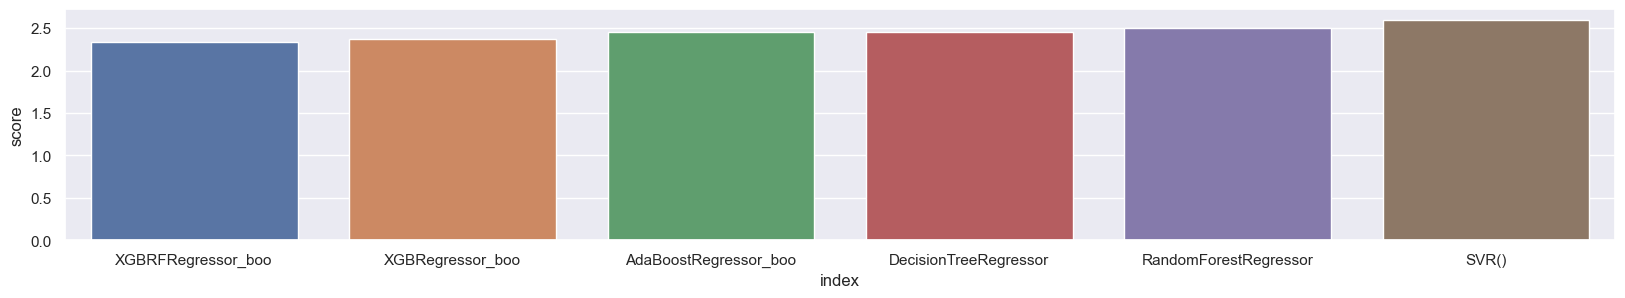

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_red_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

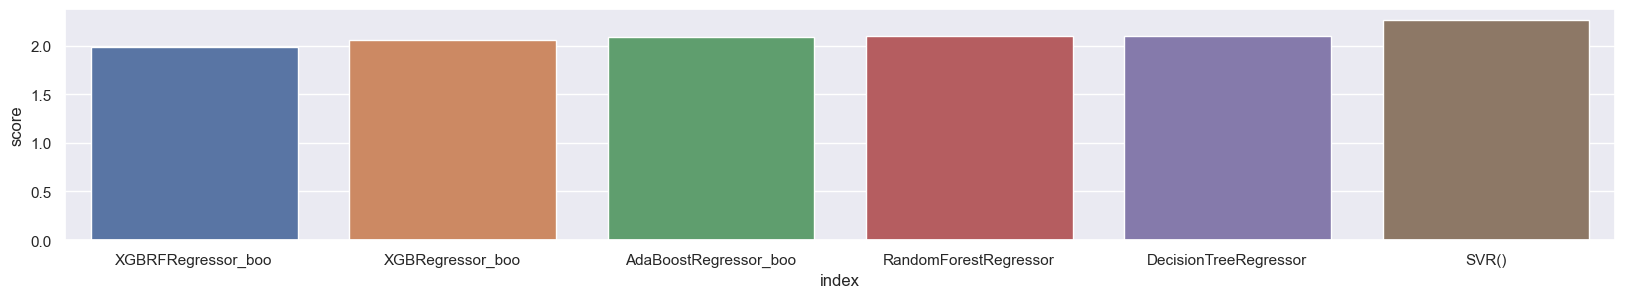

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_green_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

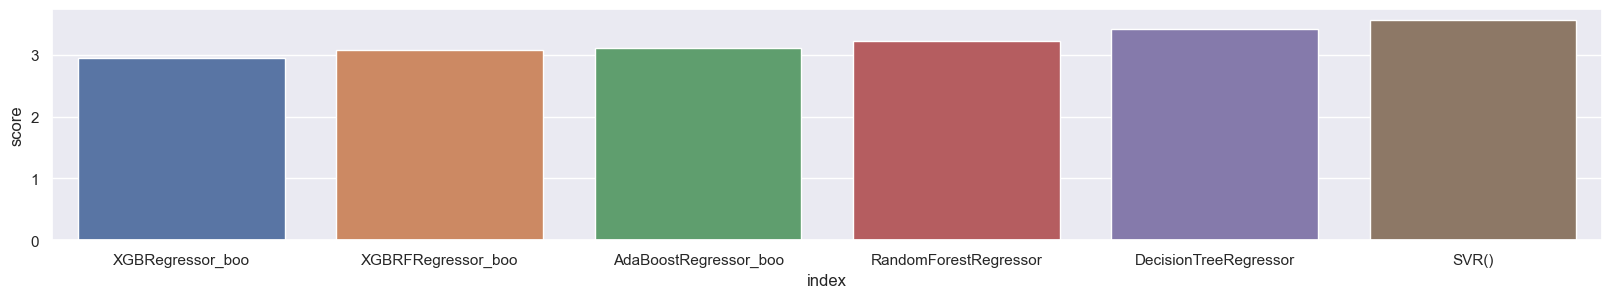

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(df_yellow_outcomes[1].mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

##### *C.3.2<BR> Outcome comparison-visualization*

##### *C.3.2.1 <BR>df_red datata set*

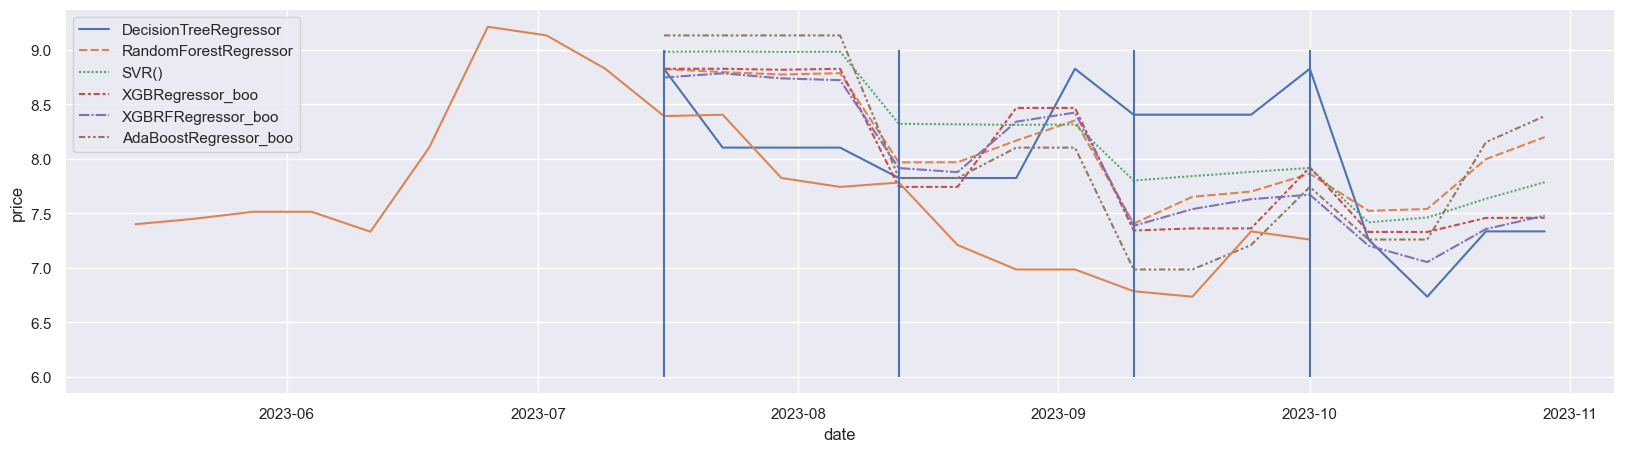

In [48]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 9
sns.lineplot(df_red_outcomes[0]);
sns.lineplot(df_red[-25:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

In [50]:

trace1=go.Line(x=df_red_outcomes[0][:-4].index,y=df_red_outcomes[0]["DecisionTreeRegressor"],name="DecisionTreeRegressor")
trace2=go.Line(x=df_red_outcomes[0][:-4].index,y=df_red_outcomes[0]["RandomForestRegressor"],name="RandomForestRegressor")
trace3=go.Line(x=df_red_outcomes[0][:-4].index,y=df_red_outcomes[0]["SVR()"],name="SVR")
trace5=go.Line(x=df_red_outcomes[0][:-4].index,y=df_red_outcomes[0]["XGBRegressor_boo"],name="XGBRegressor_")
trace6=go.Line(x=df_red_outcomes[0][:-4].index,y=df_red_outcomes[0]['AdaBoostRegressor_boo'],name="AdaBoostRegressor")
trace7=go.Line(x=df_red_outcomes[0][:-4].index,y=df_red_outcomes[0]['XGBRFRegressor_boo'],name="XGBRFRegressor")
trace8=go.Line(x=df_red[-25:-4].index,y=df_red[-25:-4]["price"],name="actual_red")
data=[trace1,trace2,trace3,trace5,trace6,trace7,trace8]

layout=dict(title='Red Popper models comparison')
fig=dict(data=data,layout=layout)
iplot(fig,filename="all red models comparison");
#fig = go.Figure(dict(data=data, layout=layout))
#fig.write_html(r"C:\Users\Omar\Intern_Final_Project\Visualization\all_red_models_comparison.html")


##### *C.3.2.2 <BR>df_green datata set*

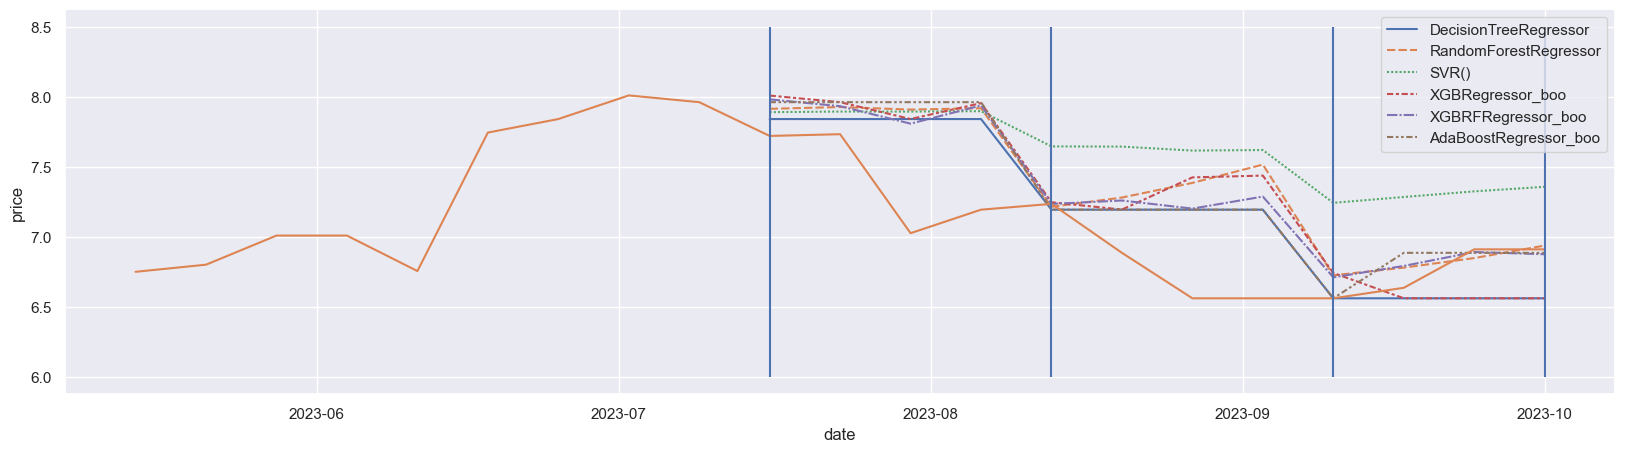

In [51]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 8.5
sns.lineplot(df_green_outcomes[0][:-4]);
sns.lineplot(df_green[-25:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

In [53]:
trace1=go.Line(x=df_green_outcomes[0].index,y=df_green_outcomes[0]["DecisionTreeRegressor"],name="DecisionTreeRegressor")
trace2=go.Line(x=df_green_outcomes[0].index,y=df_green_outcomes[0]["RandomForestRegressor"],name="RandomForestRegressor")
trace3=go.Line(x=df_green_outcomes[0].index,y=df_green_outcomes[0]["SVR()"],name="SVR")
trace5=go.Line(x=df_green_outcomes[0].index,y=df_green_outcomes[0]["XGBRegressor_boo"],name="XGBRegressor_")
trace6=go.Line(x=df_green_outcomes[0].index,y=df_green_outcomes[0]['AdaBoostRegressor_boo'],name="AdaBoostRegressor")
trace7=go.Line(x=df_green_outcomes[0].index,y=df_green_outcomes[0]['XGBRFRegressor_boo'],name="XGBRFRegressor")
trace8=go.Line(x=df_green[-25:-4].index,y=df_green[-25:-4]["price"],name="actual_green")
data=[trace1,trace2,trace3,trace4,trace5,trace6,trace7,trace8]

layout=dict(title='Green Popper models comparison')
fig=dict(data=data,layout=layout)
iplot(fig,filename="all green models comparison");
#fig = go.Figure(dict(data=data, layout=layout))
#fig.write_html(r"C:\Users\Omar\Intern_Final_Project\Visualization\all_green_models_comparison.html")

##### *C.3.2.3 <BR>df_yellow datata set*

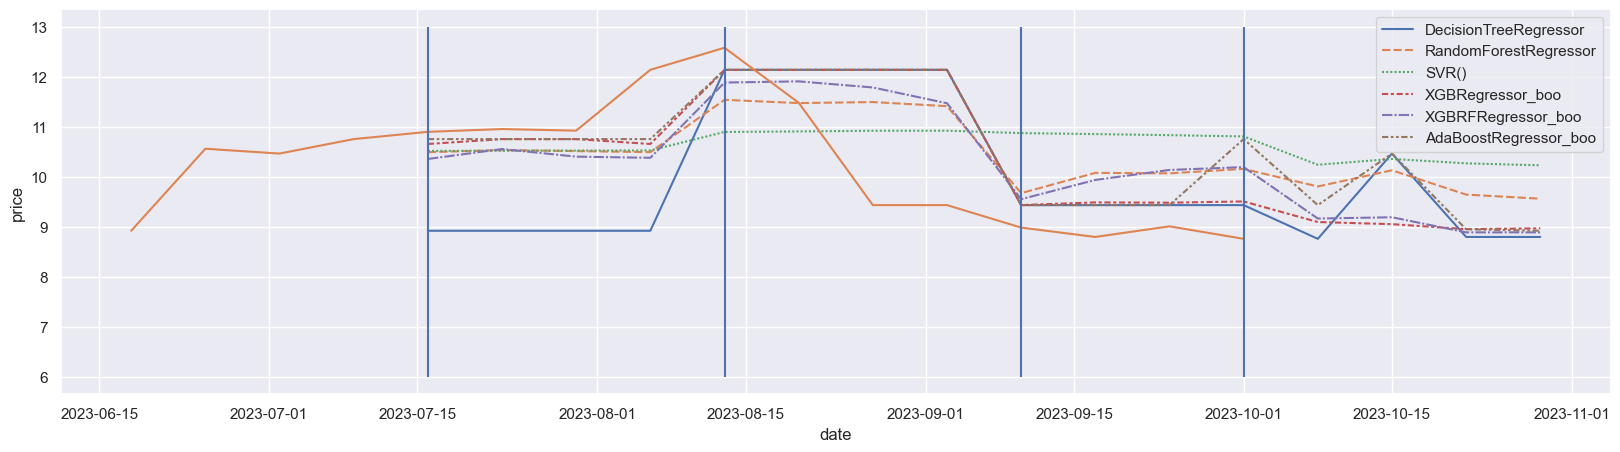

In [54]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6 
y_max = 13
sns.lineplot(df_yellow_outcomes[0]);
sns.lineplot(df_yellow[-20:-4]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

---

## *Hyperparamers tunning*

In [61]:
from hyperopt import fmin,tpe,STATUS_OK,Trials,hp
from sklearn.model_selection import TimeSeriesSplit

In [92]:
space = {
  'colsample_bynode': hp.uniform("colsample_bynode", 0.5,1), 
  "learning_rate": hp.uniform("learning_rate", 0, 1),
  'max_depth': hp.choice("max_depth", np.arange(1,20,1)),
  "num_parallel_tree": 100,
  "subsample": hp.uniform("subsample", 0.5,1)
}

In [102]:
def objective(space):
   tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
   test_data=df_red[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = XGBRFRegressor(max_depth=int(space['max_depth']),
                                                           colsample_bynode=float(space["colsample_bynode"]),                                                           
                                                           learning_rate=float(space['learning_rate']),
                                                           num_parallel_tree=int(space['num_parallel_tree']),
                                                           subsample=float(space['subsample'])
                                                                 )  
                                  
                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae=np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }
              
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)              

100%|██████████| 100/100 [00:04<00:00, 21.58trial/s, best loss: 0.25679631041107154]
{'colsample_bynode': 0.942245610289758, 'learning_rate': 0.9437025416228272, 'max_depth': 1, 'subsample': 0.6219573173600658}


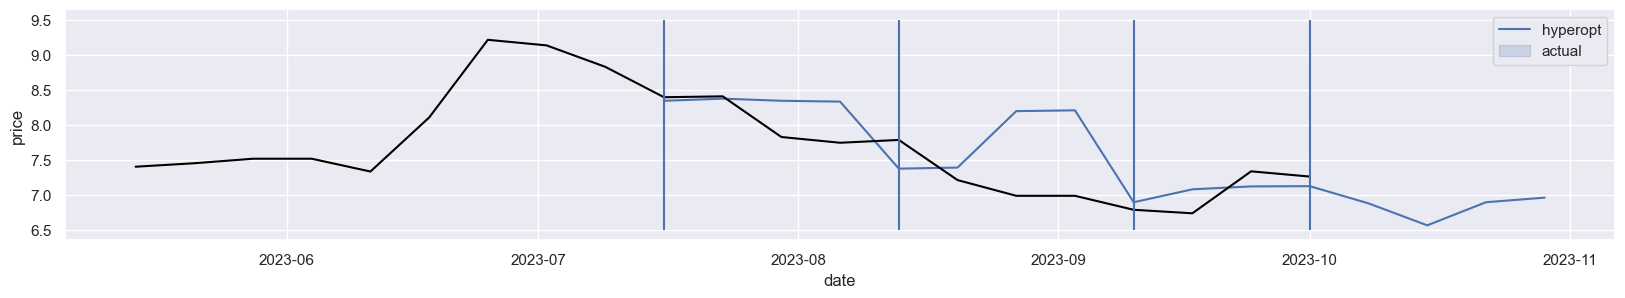

In [182]:
tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
y_pred_results_red=[]
test_data=df_red[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=XGBRFRegressor(max_depth=int(best['max_depth']),
                                       colsample_bynode=float(best["colsample_bynode"]),                                                           
                                       learning_rate=float(best['learning_rate']),
                                       #num_parallel_tree=int(best['num_parallel_tree']),
                                       subsample=float(best['subsample'])).fit(X_train,y_train)
                 
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results_red.append(y_pred)
                outcome_red_XGBRFRegressor=pd.DataFrame(pd.DataFrame(y_pred_results_red[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_red_XGBRFRegressor_all=pd.concat([outcome_red_XGBRFRegressor,new_date_index],axis=1).set_index("date")
                                


fig, ax = plt.subplots(figsize = (20,3));
y_min = 6.5
y_max = 9.5
#sns.lineplot(df_red_outcomes[0]["XGBRFRegressor_boo"],color="blue");
sns.lineplot(outcome_red_XGBRFRegressor_all,color="red");
sns.lineplot(df_red['price'][-25:-4],color="black");      
plt.legend(["hyperopt","actual"])       
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)  
fig.show()


In [143]:
def objective(space):
   tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
   test_data=df_green[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = XGBRFRegressor(max_depth=int(space['max_depth']),
                                                           colsample_bynode=float(space["colsample_bynode"]),                                                           
                                                           learning_rate=float(space['learning_rate']),
                                                           num_parallel_tree=int(space['num_parallel_tree']),
                                                           subsample=float(space['subsample'])
                                                                 )  
                                  
                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae=np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }
              
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)              

100%|██████████| 100/100 [00:04<00:00, 21.93trial/s, best loss: 0.25230831955871613]
{'colsample_bynode': 0.9112815263775949, 'learning_rate': 0.9453753767898615, 'max_depth': 3, 'subsample': 0.9648119850775193}


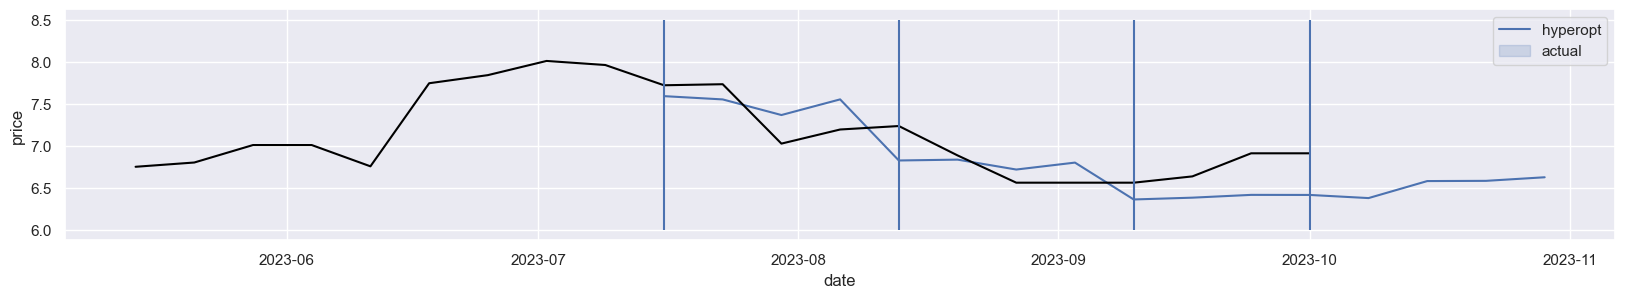

In [183]:
tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
y_pred_results_green=[]
test_data=df_green[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=XGBRFRegressor(max_depth=int(best['max_depth']),
                                       colsample_bynode=float(best["colsample_bynode"]),                                                           
                                       learning_rate=float(best['learning_rate']),
                                       #num_parallel_tree=int(best['num_parallel_tree']),
                                       subsample=float(best['subsample'])).fit(X_train,y_train)
                 
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results_green.append(y_pred)
                outcome_green_XGBRFRegressor=pd.DataFrame(pd.DataFrame(y_pred_results_green[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_green_XGBRFRegressor_all=pd.concat([outcome_green_XGBRFRegressor,new_date_index],axis=1).set_index("date")
                                


fig, ax = plt.subplots(figsize = (20,3));
y_min = 6 
y_max = 8.5
#sns.lineplot(df_green_outcomes[0]["XGBRFRegressor_boo"],color="blue");
sns.lineplot(outcome_green_XGBRFRegressor_all,color="green");
sns.lineplot(df_green['price'][-25:-4],color="black");      
plt.legend(["hyperopt","actual"])       
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)  
fig.show()


In [184]:
space = {
    'max_depth': hp.quniform("max_depth", 3,10,1),
    'eta'      : hp.loguniform("eta", -5, 1),
    'gamma'    : hp.loguniform("gamma", -5, 1),
    'colsample_bytree': hp.uniform("colsample_bytree", 0.7,1),
    'subsample':hp.uniform("subsample",.7,1),
    'n_estimators': hp.quniform("n_estimators", 100,1000,1)
     }

In [194]:
def objective(space):
   tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
   test_data=df_yellow[-20:]
   time_series_data = test_data.values
   for train_index, test_index in tscv.split(time_series_data):
                                  X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                                  X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                                  model_opt = XGBRegressor(max_depth=int(space['max_depth']),
                                                           eta=float(space['eta']),
                                                           gamma=float(space['gamma']),
                                                           colsample_bytree=float(space['colsample_bytree']),
                                                           subsample=float(space["subsample"]),
                                                           n_estimators=int(space['n_estimators'])                                                   
                                                                 )  
                                  
                                  model_opt.fit(X_train,y_train)
                                  mae_scores =[]
                                  mae=mean_absolute_error(y_test,model_opt.predict(X_test))
                                  mae_scores.append(mae)
                                  mean_mae=np.mean(mae_scores)
                                  return {
                                          'loss': mean_mae,
                                          'status': STATUS_OK
                                          }
              
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
print(best)              

100%|██████████| 100/100 [00:29<00:00,  3.37trial/s, best loss: 0.32407467536010737]
{'colsample_bytree': 0.9742025166965197, 'eta': 1.6329875115521326, 'gamma': 0.32717559887201936, 'max_depth': 9.0, 'n_estimators': 537.0, 'subsample': 0.7830381702043432}


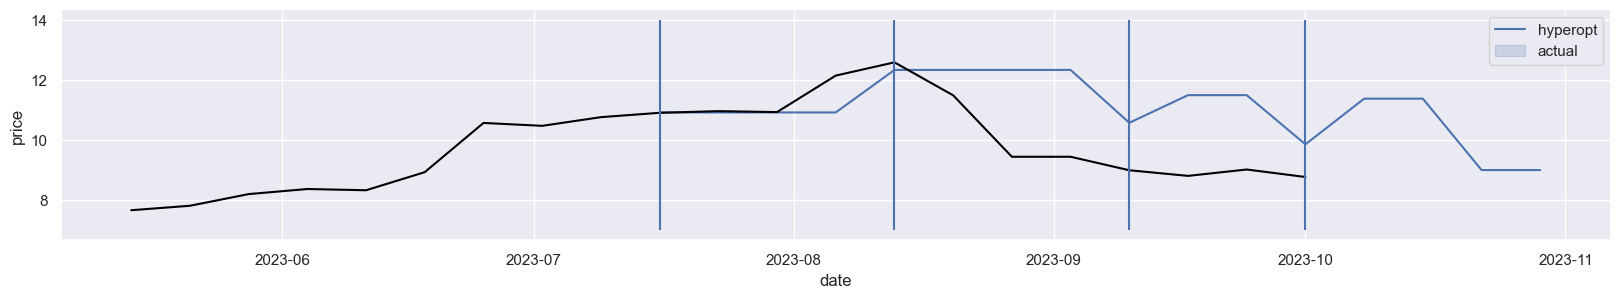

In [195]:
tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
y_pred_results_yellow=[]
test_data=df_yellow[-20:]
time_series_data = test_data.values
for train_index, test_index in tscv.split(time_series_data):
                X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
                X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]

                RF_Hyop=XGBRegressor(max_depth=int(best['max_depth']),
                                     eta=float(best['eta']),
                                     gamma=float(best['gamma']),
                                     colsample_bytree=float(best['colsample_bytree']),
                                     subsample=float(best["subsample"]),                                 
                                     n_estimators=int(best['n_estimators'])).fit(X_train,y_train)
                 
                y_pred = RF_Hyop.predict(X_test)
                y_pred_results_yellow.append(y_pred)
                outcome_yellow_XGBRegressor=pd.DataFrame(pd.DataFrame(y_pred_results_yellow[0:4]).stack().reset_index(drop=True))
                new_date_index=pd.date_range(start="2023-07-16",end="2023-10-29",freq="W")
                new_date_index=pd.DataFrame({"date":new_date_index})
                outcome_yellow_XGBRegressor_all=pd.concat([outcome_yellow_XGBRegressor,new_date_index],axis=1).set_index("date")
                                


fig, ax = plt.subplots(figsize = (20,3));
y_min = 7
y_max = 14
#sns.lineplot(df_yellow_outcomes[0]['XGBRegressor_boo'],legend=True,color="red");
sns.lineplot(outcome_yellow_XGBRegressor_all,legend=True,color="yellow");
sns.lineplot(df_yellow['price'][-25:-4],legend=True,color="black");      
plt.legend(["hyperopt","actual"])       
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)  
fig.show()


## *Final Results*

#### *Best Predicted Price for Red_Color:*

In [200]:
outcome_red_XGBRFRegressor_all[-4:]

,0
date,
2023-10-08,6.876821
2023-10-15,6.562977
2023-10-22,6.893074
2023-10-29,6.958535


#### *Best Predicted Price for green_Color:*

In [201]:
outcome_green_XGBRFRegressor_all[-4:]

,0
date,
2023-10-08,6.376969
2023-10-15,6.579494
2023-10-22,6.582155
2023-10-29,6.624817


#### *Best Predicted Price for yellow_Color:*

In [199]:
outcome_yellow_XGBRegressor_all[-4:]

,0
date,
2023-10-08,11.369586
2023-10-15,11.369586
2023-10-22,8.989764
2023-10-29,8.989764
